In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.metrics import classification_report
import seaborn as sn; sn.set(font_scale=1.4)
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tqdm import tqdm
import os
import random

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten

In [2]:
class_names=['buildings', 'forest', 'glacier','mountain','sea','street']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}
nb_classes=len(class_names)
print(class_names_label)
image_size=(150,150)

{'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}


In [3]:
#load dataset
def load_data():
    directory=os.path.abspath("")
    directory=directory + "\dataset"
    #print(directory)
    category=['seg_train','seg_test']
    output=[]
    for eachcategory in category:
        #print(eachcategory)
        path=os.path.join(directory,eachcategory)
        #print(path)
        images=[]
        labels=[]
        #print('Loading {}'. format(eachcategory) + '...')
        
        for folder in os.listdir(path):
            label=class_names_label[folder]
            for file in os.listdir(os.path.join(path, folder)):
                img_path=os.path.join(os.path.join(path,folder),file)
                #print(img_path)
                image=cv2.imread(img_path)
                image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image=cv2.resize(image,image_size)
                
                images.append(image)
                labels.append(label)
        images=np.array(images, dtype='float32')
        labels=np.array(labels, dtype='int32')
        
        output.append((images,labels))
    return output
print('Data loaded...')

Data loaded...


In [4]:
(train_images, train_labels), (test_images, test_labels) = load_data()

In [5]:
train_images, train_labels = shuffle(train_images, train_labels, random_state=25)
print(len(train_labels))

13981


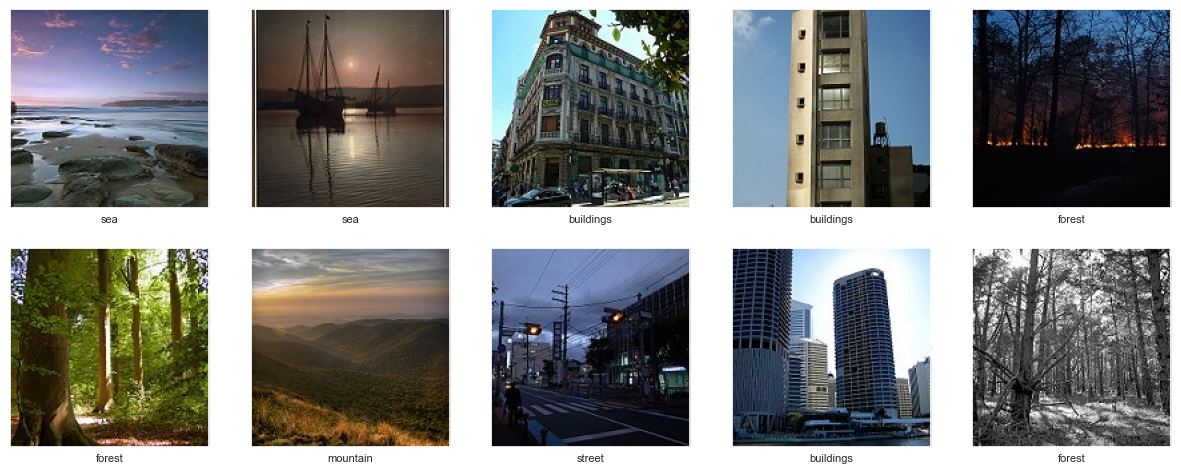

In [6]:
def display_example(class_name, images, labels):
    figsize=(15,15)
    fig=plt.figure(figsize=figsize)
    #fig.subtitle("Some examples of images from the datset", fontsize=16) - deprecated?
    for i in range(10):
        plt.subplot(5,5, i+1)
        plt.yticks([])
        plt.xticks([])
        plt.grid(False)
        #image=cv2.resize(images[i], figsize)
        #plt.imshow(image.astype(np.uint8))
        plt.imshow(images[i].astype(np.uint8))
        plt.xlabel(class_names[labels[i]],fontsize = 8)
    plt.show()

display_example(class_names,train_images,train_labels)

In [7]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(train_images)
X_test_scaled = scaler.transform(test_images)

ValueError: Found array with dim 4. MinMaxScaler expected <= 2.

In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
rescaled = ImageDataGenerator(1/255)
train_fed = rescaled.flow_from_directory('dataset/seg_train', target_size = (150,150), batch_size = 32, class_mode = 'categorical')
test_fed = rescaled.flow_from_directory('dataset/seg_test', target_size = (150,150), batch_size = 32, class_mode = 'categorical')

Found 13981 images belonging to 6 classes.
Found 2964 images belonging to 6 classes.


In [17]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import h5py 

In [18]:
erl_stop = EarlyStopping(monitor='val_loss', patience = 6, restore_best_weights=True)
mod_chk = ModelCheckpoint(filepath='my_model.hdf5', monitor='val_loss', save_best_only=True)
lr_rate = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.1)

In [19]:
model = Sequential([
        tf.keras.layers.Conv2D(16, (3,3), activation = 'relu', input_shape = (150, 150, 3)),
        tf.keras.layers.MaxPool2D(2,2),

        tf.keras.layers.Conv2D(32, (3,3), activation = 'relu'),
        tf.keras.layers.MaxPool2D(2,2),

        tf.keras.layers.Conv2D(64, (3,3), activation = 'relu'),
        tf.keras.layers.MaxPool2D(2,2),

        tf.keras.layers.Conv2D(128, (3,3), activation = 'relu'),
        tf.keras.layers.MaxPool2D(2,2),

        tf.keras.layers.Flatten(),

        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(6, activation='softmax')
    ])

In [22]:
#model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [23]:
#model.fit(train_images, train_labels, batch_size=64,epochs=4)
#history=model.fit(train_images, train_labels, batch_size=128,epochs=100,validation_split=0.2)
history = model.fit_generator(train_fed, shuffle=True, epochs=20, validation_data=test_fed , 
                              callbacks=[erl_stop, mod_chk, lr_rate], verbose=2)

Epoch 1/20


C:\Users\tyuga\AppData\Local\Temp\ipykernel_2488\3056710402.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_fed, shuffle=True, epochs=20, validation_data=test_fed ,


437/437 - 100s - loss: 1.6082 - accuracy: 0.4048 - val_loss: 1.0089 - val_accuracy: 0.6022 - lr: 0.0010 - 100s/epoch - 229ms/step
Epoch 2/20
437/437 - 93s - loss: 1.0214 - accuracy: 0.5975 - val_loss: 0.9065 - val_accuracy: 0.6616 - lr: 0.0010 - 93s/epoch - 212ms/step
Epoch 3/20
437/437 - 93s - loss: 0.8537 - accuracy: 0.6781 - val_loss: 0.7097 - val_accuracy: 0.7308 - lr: 0.0010 - 93s/epoch - 212ms/step
Epoch 4/20
437/437 - 93s - loss: 0.7572 - accuracy: 0.7238 - val_loss: 0.6320 - val_accuracy: 0.7898 - lr: 0.0010 - 93s/epoch - 213ms/step
Epoch 5/20
437/437 - 92s - loss: 0.6904 - accuracy: 0.7483 - val_loss: 0.5902 - val_accuracy: 0.7763 - lr: 0.0010 - 92s/epoch - 211ms/step
Epoch 6/20
437/437 - 93s - loss: 0.6228 - accuracy: 0.7763 - val_loss: 0.6462 - val_accuracy: 0.7692 - lr: 0.0010 - 93s/epoch - 214ms/step
Epoch 7/20
437/437 - 93s - loss: 0.5597 - accuracy: 0.8018 - val_loss: 0.5899 - val_accuracy: 0.7848 - lr: 0.0010 - 93s/epoch - 213ms/step
Epoch 8/20
437/437 - 92s - loss: 0.5

In [24]:
def plot_accuracy_loss(history):
    fig=plt.figure(figsize=(20,10))
    plt.subplot(221)
    plt.plot(history.history['accuracy'], 'bo--', label='acc')
    plt.plot(history.history['val_accuracy'], 'ro--', label='val_acc')
    plt.title('train_acc VS val_acc')
    plt.ylabel('accuracy')
    plt.xlabel('epochs')
    plt.grid(color = 'grey', linestyle = '--', linewidth = 0.5)
    plt.rcParams['axes.facecolor'] = 'white'
    plt.legend(fontsize = "large")

    
    plt.subplot(222)
    plt.plot(history.history['loss'], 'bo--', label='loss')
    plt.plot(history.history['val_loss'], 'ro--', label='val_loss')
    plt.title('train_loss VS val_loss')
    plt.ylabel('loss')
    plt.xlabel('epochs')
    plt.grid(color = 'grey', linestyle = '--', linewidth = 0.5)
    plt.rcParams['axes.facecolor'] = 'white'
    plt.legend()

    
    plt.show()   

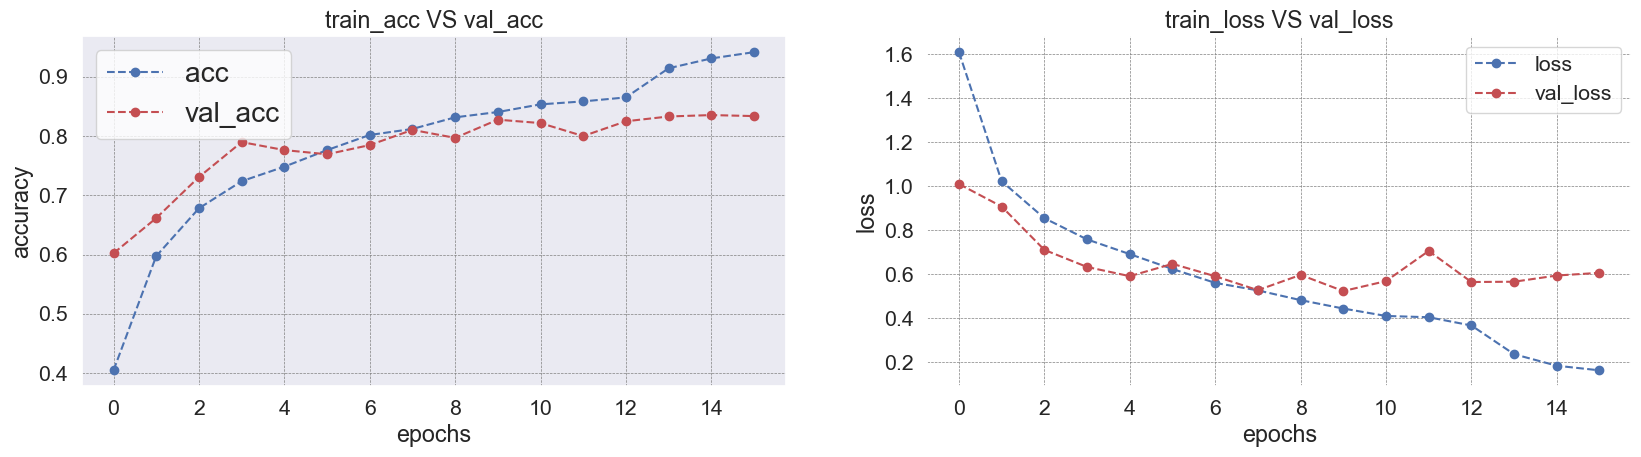

In [25]:
plot_accuracy_loss(history)

In [30]:
model.save('model/')

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


In [ ]:
print("We have " + str(len(train_images)) + " of images in " + str(len(class_names_label)) + " classes")
print("And " + str(len(test_images)) + " test images")

In [ ]:
pred_images = model.predict(test_images) #this is vector of probabilities
pred_labels = np.argmax(pred_images, axis=1) #take the highest one prob.
print(classification_report(test_labels, pred_labels))

In [ ]:
#Precision is the ratio of the correctly +ve labeled by our program to all +ve labeled
#Precision answers the following: How many of those who we labeled as diabetic are actually diabetic
#Recall is the ratio of the correctly +ve labeled by our program to all who are diabetic in reality.
#Recall answers the following question: Of all the people who are diabetic, how many of those we correctly predict?
#F1 Score considers both precision and recall.
#It is the harmonic mean(average) of the precision and recall

In [ ]:
directory=os.path.abspath("")
test_image_filename='testimage1.jpg'
img_path=os.path.join(directory,test_image_filename)

image=cv2.imread(img_path)
image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image=cv2.resize(image,image_size)

figsize=(5,5)
fig=plt.figure(figsize=figsize)
plt.imshow(image)
plt.grid(False)
plt.show
image.reshape

y_pred=model.predict(image.reshape(1, 150,150,3))

pred_label = np.argmax(y_pred, axis=1)
print("Results of image classification:", y_pred)
np.set_printoptions(suppress=True)
print("Rounded predict values:", np.around(y_pred, decimals=2))
print("Our image belongs to class:", class_names[pred_label[0]])